In [11]:
import shutil
import apiquery
import pandas as pd
import seaborn as sns
import os
import numpy as np
import random
DATA_PATH = '../01.Data'
shutil.copy("apiquery_pyc.py", "apiquery.pyc")
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
import math
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import math
import time
!pip install lightgbm
import lightgbm as lgbm
import matplotlib.pyplot as plt

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


## 1. Preprocessing

In [12]:
def seed_everything(seed=42):
    '''
    Function to put a seed to every step and make code reproducible
    Input:
    - seed: random state for the events 
    '''
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    
def Training_Lightgbm(df,params,fold_column = 'fold',target_column = 'target',cat_vars = [],metric = 'RMSE',early_stopping = 200,max_boost_round = 8000):
    tr_metric  = []
    val_metric = []
    importances = pd.DataFrame()
    importances['Features'] = df.drop(columns  = [fold_column,target_column]).columns[:]
    models = []
    oof = np.zeros((len(df)))
    start = int(time.time() * 1000)
    for i in range(len(df[fold_column].unique())):
      # Get the train and Valid sets
        df_tr  = df[df[fold_column]!=i].reset_index(drop  = True)
        df_val = df[df[fold_column]==i].reset_index(drop  = True)
        # Split by independent and dependent variables
        X_train, y_train = df_tr.drop(columns  = [fold_column,target_column]) , df_tr[target_column]
        X_valid, y_valid = df_val.drop(columns  = [fold_column,target_column]), df_val[target_column]
        feature_list = X_train.columns.to_list()
        print(f"Columns: {X_train.columns.to_list()}")
        # Index for categorical variable if exist
        if cat_vars:
            features = [x for x in X_train.columns]
            cat_ind = [features.index(x) for x in cat_vars]
        else:
            cat_ind = []
        print('Cat index:', cat_ind)
        # Create lgbm Dataset 
        lgbm_train = lgbm.Dataset(X_train, label = y_train,categorical_feature= cat_ind)
        lgbm_eval  = lgbm.Dataset(X_valid, y_valid, reference = lgbm_train,categorical_feature=cat_ind)

        # Training lgbm model
        print('---------- Training fold Nº {} ----------'.format(i+1))
        lgbm_model = lgbm.train(params,lgbm_train,num_boost_round = max_boost_round,early_stopping_rounds = early_stopping, verbose_eval=50, categorical_feature=cat_ind,valid_sets=[lgbm_train,lgbm_eval]) 
        # Initialize Importances
        name = 'importance_'+str(i)
        importances[name]= lgbm_model.feature_importance(importance_type = 'gain')
        # Saving Model
        models.append(lgbm_model)
        # Saving oof predictions
        valid_idx = df[df[fold_column] == i].index
        # Evaluating Metrics for train and Validation
        y_train_pred = lgbm_model.predict(X_train,num_iteration=lgbm_model.best_iteration)
        tr_metric    += [math.sqrt(mean_squared_error(y_train, y_train_pred))]

        y_valid_pred   = lgbm_model.predict(X_valid,num_iteration=lgbm_model.best_iteration)
        val_metric    += [math.sqrt(mean_squared_error(y_valid, y_valid_pred))]
        oof[valid_idx] = y_valid_pred
        print(f"Train {metric}: {tr_metric[-1]}        Valida {metric}: {val_metric[-1]}")
    end = int(time.time() * 1000)
    results = pd.DataFrame({'Model_Name'           : ['Lgbm Model'],
                          f'Mean Valid {metric}' : [np.mean(val_metric)],
                          f'Std Valid {metric}'  : [np.std(val_metric)],
                          f'Mean Train {metric}' : [np.mean(tr_metric)],
                          f'Std Train {metric}'  : [np.std(tr_metric)],
                          f'OOF {metric}'        : [math.sqrt(mean_squared_error(df[target_column].values, oof))],
                          f'Diff {metric}'       : [np.mean(tr_metric) - np.mean(val_metric)],
                          'Time'                 : [str(end-start) + ' s']})
    print(f'OOF {metric}: {math.sqrt(mean_squared_error(df[target_column].values, oof))} ')                         
    return results,models,importances,oof,feature_list

In [13]:
def label_encoding(df,label_cols = [], drop_original = True, missing_new_cat = True):
    '''
    Function to get the encoding Label of a variable
    Input:
    -df         : Dataframe al cual se le aplica one hot encoding
    -label_cols : Variables categoricas
    '''
    from sklearn import preprocessing
    df_     = df.copy()
    df_cols = df[label_cols].copy().rename(columns = { i : 'label_' + i for i in label_cols})
    dict_le ={}
    if missing_new_cat:
        print('Mode: Missing as new category')
        for i in df_cols.columns:
            le = preprocessing.LabelEncoder()
            print('Label Encoding: ',i)
            df_cols[i] = df_cols[i].astype('str')
            le.fit(df_cols[i])
            df_cols[i] = le.transform(df_cols[i])
            var_name = i
            dict_le[var_name] = le
    else:
        print('Mode: Missing as -1')
        for i in df_cols.columns:
            df_cols[i] = df_cols[i].fillna('NaN')
            df_cols[i] = df_cols[i].astype('str')
            le = preprocessing.LabelEncoder()
            print('Label Encoding: ',i)
            a = df_cols[i][df_cols[i]!='NaN']
            b = df_cols[i].values
            le.fit(a)
            b[b!='NaN']  = le.transform(a)
            df_cols[i] = b
            df_cols[i] = df_cols[i].replace({'NaN':-1})
            var_name = i
            dict_le[var_name] = le

    df_ = pd.concat([df_ , df_cols], axis = 1) 
    if drop_original:
        df_.drop(columns = label_cols, inplace = True)
    return df_,dict_le

def apply_label_encoder(df,dict_label_encoder,drop_original = True, missing_new_cat = True):
    from sklearn import preprocessing
    df_     = df.copy()
    label_cols = [i[6:] for i in list(dict_label_encoder.keys())]
    df_cols = df[label_cols].copy().rename(columns = { i : 'label_' + i for i in label_cols})
    if missing_new_cat:
        print('Mode: Missing as new category')
        for i in df_cols.columns:
            print('Applying Label Encoding: ',i)
            df_cols[i] = df_cols[i].astype('str')
            le = dict_label_encoder[i]
            df_cols[i] = le.transform(df_cols[i])
  
    else:
        print('Mode: Missing as -1')
        for i in df_cols.columns:
            df_cols[i] = df_cols[i].fillna('NaN')
            df_cols[i] = df_cols[i].astype('str')
            print('Applying Label Encoding: ',i)
            a = df_cols[i][df_cols[i]!='NaN']
            b = df_cols[i].values
            le = dict_label_encoder[i]
            b[b!='NaN']  = le.transform(a)
            df_cols[i] = b
            df_cols[i] = df_cols[i].replace({'NaN':-1})

    df_ = pd.concat([df_ , df_cols], axis = 1) 
    if drop_original:
        df_.drop(columns = label_cols, inplace = True)
    return df_  

In [14]:
def extract_time(df,column):
    date    = pd.to_datetime(df[column])
    df[f'{column}_year']   = date.dt.year.values
    df[f'{column}_month']  = date.dt.month.values
    df[f'{column}_day']    = date.dt.day.values
    df[f'{column}_hour']   = date.dt.hour.values
    df[f'{column}_minute'] = date.dt.minute.values
    df[f'{column}_second'] = date.dt.second.values
    df.drop(columns = [column],inplace = True)

def multiple_extract_time(df,columns):
    for i in columns:
        extract_time(df,i)
        
def resumen_vars(df,columns):
    for i in columns:
        print(f"{'*'*20} Column: {i} {'*'*20}")
        print(f'- Value counts:')
        print(df[i].value_counts(dropna = False))
        print(f'- Nunique values {i}:\n',df[i].nunique())
        
def porc_na(df):
    df_na = pd.DataFrame({'Variable'      : df.columns.values,
                          'Missing (%)'     : np.round(100 * df.isna().sum().values / df.shape[0] ,3)})
    return df_na

def isNaN(string):
    return string != string

def split_double_dot(row,column):
    if isNaN(row[column]):
        return np.nan,np.nan
    elif len(row[column].split(':'))==1:
        return np.nan,row[column]
    else:
        list_split = row[column].split(':')
        return list_split[0],list_split[1]
    
def split_by_comma(row,column):
    list_split = row[column].split(',')
    return list_split[0],list_split[1],list_split[2],list_split[3],list_split[4],list_split[5],list_split[-6],list_split[-5],list_split[-4],list_split[-3],list_split[-2],list_split[-1]

def func_formatting(row):
    if isNaN(row):
        return np.nan
    else:
        row = row.replace('-',' ').lower()
        row = " ".join(row.split())
        return row
    
def func_geolocation(row):
    if isNaN(row['first_packaging_code_geo']):
        return np.nan,np.nan
    else:
        return row['first_packaging_code_geo'].split(',')[0],row['first_packaging_code_geo'].split(',')[1]
    
def func_sort_split_comma(row):
    if isNaN(row):
        return np.nan
    else:
        row = row.replace('-',' ').lower()
        row = " ".join(row.split(' '))
        row = row.split(',')
        row.sort()
        row = ",".join(row)
        return row    
    

In [15]:
def str_process(x,separator,split_str,factor=1):
    if separator in x:
        for a in x.split(split_str):
            try:
                a = int(a)*factor
                return True,a
            except:
                pass
    return False,None

metrics = [[' g',' g',1],[' kg',' kg',1000],[' oz',' oz',28.3495],[' ml',' ml',1],[' lb',' lb',453.592],[' fl',' fl',29.57352956]]

def get_quantity(x):
    if x== np.nan:
        return x
    try:
        x = int(x)
        return x
    except:
        pass
    try:
        if type(x)!= str:
            return x
        
        x = x.lower()
        
        for metric in metrics:
            band, value = str_process(x,metric[0],metric[1],metric[2])
            if band:
                return value
        
    except:
        return x

In [16]:
def func_states(row,column):
    lista_rm = []
    splits   = row[column].replace('en:','').lower().split(',')
    indexes  = ['nutrition facts','ingredients','expiration date','packaging-code-','characteristics','categories','brands','packaging','quantity','product name']
    dict_ = {}
    for sentence in splits:
        for idx in indexes:
            if idx in sentence:
                if idx == 'packaging' and ('packaging-code-' in sentence):
                    continue
                else:
                    dict_.update({idx:sentence.split(f'{idx}')[1].strip().replace('-',' ')})
                    lista_rm.append(sentence)
    
    list_keys  = list(dict_.keys())
    list_falta = list(set(indexes)-set(list_keys))
    
    for i in list_falta:
        dict_.update({i:np.nan})
    #Complete first 2 and last 2
    for i in set(lista_rm):
        splits.remove(i)
    
    lista_rm = []
    indexes_2 = ['check','complete','validate','upload']
    for sentence in splits:
        for idx in indexes_2:
            if idx in sentence:
                if (idx=='check')|(idx=='complete'):
                    dict_.update({f'general_{idx}':sentence})
                    lista_rm.append(sentence)
                    
                if (idx=='validate')|(idx=='upload'):
                    dict_.update({f'photo_{idx}':sentence})
                    lista_rm.append(sentence)
    list_keys  = list(dict_.keys())
    list_falta = list(set(['general_check','general_complete','photo_validate','photo_upload'])-set(list_keys))
    
    for i in list_falta:
        dict_.update({i:np.nan})
    
    # Sort dictionary
    dict_ = dict_.items()
    dict_ = sorted(dict_)
    dict_ = dict(dict_)

    # Return
    #'brands': 'completed',
    #'categories': 'completed',
    #'characteristics': 'completed',
    #'expiration date': 'to be completed',
    #'general_check': 'to be checked',
    #'general_complete': nan,
    #'ingredients': 'completed',
    #'nutrition facts': 'completed',
    #'packaging': 'completed',
    #'packaging-code-': 'to be completed',
    #'photo_upload': 'photos uploaded',
    #'photo_validate': 'photos validated',
    #'product name': 'completed',
    #'quantity': 'completed'

    #['brands','categories','characteristics','expiration date','general_check','general_complete',
    # 'ingredients','nutrition facts','packaging','packaging-code-','photo_upload','photo_validate',
    #'product name','quantity']
    
    return tuple(dict_.values())

In [17]:
%%time
# Reading dataframes
df_train     = pd.read_csv(os.path.join(DATA_PATH,'food_train.tsv'), index_col='Index', encoding='utf-8', sep='\t').reset_index(drop = True)
df_test      = pd.read_csv(os.path.join(DATA_PATH,'food_X_test.tsv'), index_col='Index', encoding='utf-8', sep='\t').reset_index()
df_test      = df_test.merge(pd.read_csv(os.path.join(DATA_PATH,'target_test.csv')),how = 'left',on = ['Index'])
y_submission = pd.read_csv(os.path.join(DATA_PATH,'y_test_submission_example.tsv'), index_col='Index', encoding='utf-8', sep='\t')


cols_extract_date = ['created_datetime','last_modified_datetime']
# Preprocessing
#2. 
multiple_extract_time(df_train,cols_extract_date)
multiple_extract_time(df_test,cols_extract_date)
#3. 
col = 'main_category'
df_train[[f'{col}_lang',f'{col}_cat']] = df_train.apply(lambda x: split_double_dot(x,col),axis = 1,result_type='expand')
df_test[[f'{col}_lang',f'{col}_cat']] = df_test.apply(lambda x: split_double_dot(x,col),axis = 1,result_type='expand')

col = 'main_category_en'
df_train[[f'{col}_lang',f'{col}_cat']] = df_train.apply(lambda x: split_double_dot(x,col),axis = 1,result_type='expand')
df_test[[f'{col}_lang',f'{col}_cat']] = df_test.apply(lambda x: split_double_dot(x,col),axis = 1,result_type='expand')


# Formating columns
format_cols = ['pnns_groups_1','pnns_groups_2','product_name','generic_name','packaging','packaging_tags','brands','brands_tags',
 'categories','categories_tags','origins','origins_tags','manufacturing_places','manufacturing_places_tags',
'labels','labels_tags','labels_en','emb_codes','emb_codes_tags','cities_tags','purchase_places','stores']
for i in format_cols :
    df_train[i] = df_train[i].apply(lambda x:func_formatting(x)) 
    df_test[i] = df_test[i].apply(lambda x:func_formatting(x))

# Extracting geo location:
df_train[[f'first_packaging_code_geo_x','first_packaging_code_geo_y']] = df_train.apply(lambda x: func_geolocation(x),axis = 1,result_type='expand')
df_test[[f'first_packaging_code_geo_x','first_packaging_code_geo_y']]  = df_test.apply(lambda x: func_geolocation(x),axis = 1,result_type='expand')
df_train.drop(columns = ['first_packaging_code_geo'],inplace = True)
df_test.drop(columns = ['first_packaging_code_geo'],inplace = True)

for i in ['countries_en','allergens']:
    df_train[i] = df_train[i].apply(lambda x:func_sort_split_comma(x))
    df_test[i]  = df_test[i].apply(lambda x:func_sort_split_comma(x))


cols_states_en = ['brands','categories','characteristics','expiration date','general_check','general_complete',
                 'ingredients','nutrition facts','packaging','packaging-code-','photo_upload','photo_validate',
                 'product name','quantity']
col = 'states_en'
df_train[[f'{col}_{idx}' for idx in cols_states_en]] = df_train.apply(lambda x: func_states(x,col),axis = 1,result_type='expand')
df_test[[f'{col}_{idx}' for idx in cols_states_en]] = df_test.apply(lambda x: func_states(x,col),axis = 1,result_type='expand')

# Drop some cols
cols_drop = ['ingredients_that_may_be_from_palm_oil','ingredients_from_palm_oil','no_nutriments','allergens_en','cities',
            'generic_name','categories','categories_en','origins','manufacturing_places','labels',
             'emb_codes','emb_codes_tags','cities_tags','purchase_places','stores','countries',
             'countries_en','traces','traces_en','additives_en','ingredients_from_palm_oil_tags',
             'ingredients_that_may_be_from_palm_oil_tags','ingredients_that_may_be_from_palm_oil_tags',
             'states','states_tags','main_category','main_category_en','first_packaging_code_geo_x','first_packaging_code_geo_y']

df_train.drop(columns = cols_drop,inplace = True)
df_test.drop(columns = cols_drop,inplace = True)



CPU times: user 38.9 s, sys: 2.24 s, total: 41.1 s
Wall time: 41.1 s


In [18]:
porc_na(df_train)

,Variable,Missing (%)
0,creator,0.000
1,created_t,0.000
2,last_modified_t,0.000
3,product_name,1.099
4,quantity,70.767
5,packaging,74.812
6,packaging_tags,74.813
7,brands,1.909
8,brands_tags,1.911
9,categories_tags,70.805


## 2. Future Engineering

In [19]:
def feature_engineering(df):
    df['diff_t']  = df['last_modified_t']-df['created_t']
    df.drop(columns = ['last_modified_t','created_t'],inplace = True)

In [20]:
feature_engineering(df_train)
feature_engineering(df_test)

## 3. Model Split

In [21]:
num_bins = int(np.floor(1 + np.log2(len(df_train))))
#num_bins = 10
print(f'Num bins: {num_bins}')
df_train['target_bin'] = pd.qcut(df_train['target'],num_bins,labels = False)
100*df_train['target_bin'].value_counts(normalize = True)

Num bins: 17


2     9.675775
10    9.075940
7     7.143137
8     7.093151
0     6.863802
5     6.561924
14    5.904262
16    5.847414
12    5.708237
13    5.387737
3     5.083899
1     5.083899
4     4.741836
6     4.449759
15    3.983220
9     3.939115
11    3.456894
Name: target_bin, dtype: float64

In [23]:
FOLDS = 5
SEED  = 42

df_fold = df_train.copy()
skf = StratifiedKFold(n_splits = FOLDS,shuffle = True, random_state = SEED)
df_fold['fold'] = 0
for fold,(train_index, test_index) in enumerate(skf.split(df_fold,df_fold['target_bin'])):
    df_fold.loc[test_index,'fold'] = fold
    
# Save the CSV with folds for training
df_fold.to_csv(os.path.join("../01.Data",'fold.csv'),index = False)
df_test.to_csv(os.path.join(DATA_PATH,'test_preprocessed.csv'),index = False)
df_fold.head(1)

,creator,product_name,quantity,packaging,packaging_tags,brands,brands_tags,categories_tags,origins_tags,manufacturing_places_tags,labels_tags,labels_en,countries_tags,ingredients_text,allergens,traces_tags,serving_size,additives_n,additives,additives_tags,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,pnns_groups_1,pnns_groups_2,states_en,target,created_datetime_year,created_datetime_month,created_datetime_day,created_datetime_hour,created_datetime_minute,created_datetime_second,last_modified_datetime_year,last_modified_datetime_month,last_modified_datetime_day,last_modified_datetime_hour,last_modified_datetime_minute,last_modified_datetime_second,main_category_lang,main_category_cat,main_category_en_lang,main_category_en_cat,states_en_brands,states_en_categories,states_en_characteristics,states_en_expiration date,states_en_general_check,states_en_general_complete,states_en_ingredients,states_en_nutrition facts,states_en_packaging,states_en_packaging-code-,states_en_photo_upload,states_en_photo_validate,states_en_product name,states_en_quantity,diff_t,target_bin,fold
0,usda-ndb-import,caramel creams,NaN,NaN,NaN,gold emblem,gold emblem,NaN,NaN,NaN,NaN,NaN,en:united-states,"Wheat flour, corn syrup, dextrose, sugar, part...",NaN,NaN,34 g (3 PIECES),1.0,[ wheat-flour -> en:wheat-flour ] [ flour -...,"en:e322,en:e322i",0.0,0.0,NaN,NaN,"To be completed,Nutrition facts completed,Ingr...",11.0,2017,3,10,8,46,35,2017,3,10,8,46,35,NaN,NaN,NaN,NaN,completed,to be completed,to be completed,to be completed,NaN,to be completed,completed,completed,to be completed,to be completed,photos to be uploaded,NaN,completed,to be completed,0,8,2


In [24]:
df_fold.groupby('fold')['target'].mean()

fold
0    9.167353
1    9.173527
2    9.168235
3    9.171870
4    9.172262
Name: target, dtype: float64

## 4. Modeling

In [25]:
%%time
df_train = pd.read_csv(os.path.join("../01.Data",'fold.csv'))
df_test      = pd.read_csv(os.path.join(DATA_PATH,'test_preprocessed.csv'))
y_submission = pd.read_csv(os.path.join(DATA_PATH,'y_test_submission_example.tsv'), index_col='Index', encoding='utf-8', sep='\t')
df_train.head(1)

CPU times: user 2.33 s, sys: 262 ms, total: 2.59 s
Wall time: 3.06 s


,creator,product_name,quantity,packaging,packaging_tags,brands,brands_tags,categories_tags,origins_tags,manufacturing_places_tags,labels_tags,labels_en,countries_tags,ingredients_text,allergens,traces_tags,serving_size,additives_n,additives,additives_tags,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,pnns_groups_1,pnns_groups_2,states_en,target,created_datetime_year,created_datetime_month,created_datetime_day,created_datetime_hour,created_datetime_minute,created_datetime_second,last_modified_datetime_year,last_modified_datetime_month,last_modified_datetime_day,last_modified_datetime_hour,last_modified_datetime_minute,last_modified_datetime_second,main_category_lang,main_category_cat,main_category_en_lang,main_category_en_cat,states_en_brands,states_en_categories,states_en_characteristics,states_en_expiration date,states_en_general_check,states_en_general_complete,states_en_ingredients,states_en_nutrition facts,states_en_packaging,states_en_packaging-code-,states_en_photo_upload,states_en_photo_validate,states_en_product name,states_en_quantity,diff_t,target_bin,fold
0,usda-ndb-import,caramel creams,NaN,NaN,NaN,gold emblem,gold emblem,NaN,NaN,NaN,NaN,NaN,en:united-states,"Wheat flour, corn syrup, dextrose, sugar, part...",NaN,NaN,34 g (3 PIECES),1.0,[ wheat-flour -> en:wheat-flour ] [ flour -...,"en:e322,en:e322i",0.0,0.0,NaN,NaN,"To be completed,Nutrition facts completed,Ingr...",11.0,2017,3,10,8,46,35,2017,3,10,8,46,35,NaN,NaN,NaN,NaN,completed,to be completed,to be completed,to be completed,NaN,to be completed,completed,completed,to be completed,to be completed,photos to be uploaded,NaN,completed,to be completed,0,8,2


In [26]:
df_na = porc_na(df_train)
columns = df_na[df_na['Missing (%)']<70].reset_index(drop = True).Variable.values

In [27]:
for i in columns:
    print(f'{i}: ,nunique: {df_train[i].nunique()}, -> {df_train[i].unique()}')
    print('\n')

creator: ,nunique: 1765, -> ['usda-ndb-import' 'kiliweb' 'sebleouf' ... 'citp' 'a1000s' 'andrea529']


product_name: ,nunique: 79474, -> ['caramel creams' 'potato chips, hot bar b q' 'hummus' ...
 'spinach & cheese tortellini'
 'ripe craft juice, cold pressed daily, 100% juice cranberry unsweetened'
 'hummel bros., cocktail franks']


brands: ,nunique: 25713, -> ['gold emblem' "conn's" 'sticks kebob shop' ... 'g.b. ambrosoli'
 'richgood gourmet llc' 'hummel bros.']


brands_tags: ,nunique: 24683, -> ['gold emblem' 'conn s' 'sticks kebob shop' ... 'g b ambrosoli'
 'richgood gourmet llc' 'hummel bros']


countries_tags: ,nunique: 331, -> ['en:united-states' 'en:france' 'en:france,en:switzerland'
 'en:switzerland' 'en:belgium' 'en:germany' 'en:spain'
 'en:france,en:sweden' 'en:belgium,en:france' 'en:france,en:french-guiana'
 'en:france,en:spain' 'en:france,en:germany' 'en:united-kingdom'
 'en:poland' 'en:austria,en:germany' 'en:australia' 'en:mexico'
 'en:france,en:martinique' 'en:portuga

additives: ,nunique: 81361, -> [' [ wheat-flour -> en:wheat-flour  ]  [ flour -> en:flour  ]  [ corn-syrup -> en:corn-syrup  ]  [ syrup -> en:syrup  ]  [ dextrose -> en:dextrose  ]  [ sugar -> en:sugar  ]  [ partially-hydrogenated-soybean-oil -> en:partially-hydrogenated-soybean-oil  ]  [ hydrogenated-soybean-oil -> en:hydrogenated-soybean-oil  ]  [ soybean-oil -> en:soybean-oil  ]  [ oil -> en:oil  ]  [ high-fructose-corn-syrup -> en:high-fructose-corn-syrup  ]  [ fructose-corn-syrup -> en:fructose-corn-syrup  ]  [ corn-syrup -> en:corn-syrup  ]  [ syrup -> en:syrup  ]  [ modified-whey -> en:modified-whey  ]  [ whey -> en:whey  ]  [ skim-milk -> en:skim-milk  ]  [ milk -> en:milk  ]  [ cream -> en:cream  ]  [ mono -> en:mono  ]  [ and-diglycerides -> en:and-diglycerides  ]  [ diglycerides -> en:diglycerides  ]  [ salt-soy-lecithin -> en:salt-soy-lecithin  ]  [ soy-lecithin -> en:soy-lecithin  ]  [ lecithin -> en:e322i  -> exists  -- ok  ]  [ corn-starch -> en:corn-starch  ]  [ starch 

diff_t: ,nunique: 32587, -> [       0        1        6 ...    11680    13328 90511431]


target_bin: ,nunique: 17, -> [ 8 13  1  4  6 12 15 10  5  2 16 14  9  3 11  7  0]


fold: ,nunique: 5, -> [2 3 1 0 4]




In [28]:
columns_modeling = ['additives_n','ingredients_from_palm_oil_n',
                    'ingredients_that_may_be_from_palm_oil_n','target',
                    'states_en_brands','states_en_categories','states_en_characteristics','states_en_expiration date',
                    'states_en_general_complete','states_en_ingredients','pnns_groups_1','pnns_groups_2',
                    'states_en_packaging','states_en_packaging-code-','states_en_photo_upload',
                    'states_en_photo_validate','states_en_product name','states_en_quantity','diff_t']
columns_label = df_train[columns_modeling].select_dtypes(include=['object']).columns.to_list()
print(columns_label)

['states_en_brands', 'states_en_categories', 'states_en_characteristics', 'states_en_expiration date', 'states_en_general_complete', 'states_en_ingredients', 'pnns_groups_1', 'pnns_groups_2', 'states_en_packaging', 'states_en_packaging-code-', 'states_en_photo_upload', 'states_en_photo_validate', 'states_en_product name', 'states_en_quantity']


In [29]:
for i in columns_label:
    print(f"{'*'*20} {i} {'*'*20}")
    print('Train - Test',set(df_train[i].unique())-set(df_test[i].unique()))
    print('Test - Train',set(df_test[i].unique())-set(df_train[i].unique()))

******************** states_en_brands ********************
Train - Test {nan}
Test - Train set()
******************** states_en_categories ********************
Train - Test {nan}
Test - Train set()
******************** states_en_characteristics ********************
Train - Test set()
Test - Train set()
******************** states_en_expiration date ********************
Train - Test set()
Test - Train set()
******************** states_en_general_complete ********************
Train - Test set()
Test - Train set()
******************** states_en_ingredients ********************
Train - Test set()
Test - Train set()
******************** pnns_groups_1 ********************
Train - Test set()
Test - Train set()
******************** pnns_groups_2 ********************
Train - Test set()
Test - Train set()
******************** states_en_packaging ********************
Train - Test {nan}
Test - Train set()
******************** states_en_packaging-code- ********************
Train - Test set()
Test -

In [30]:
df_train,dict_le = label_encoding(df_train,label_cols = columns_label, drop_original = True, missing_new_cat = True)
df_test = apply_label_encoder(df_test,dict_le,drop_original = True, missing_new_cat = True)

Mode: Missing as new category
Label Encoding:  label_states_en_brands
Label Encoding:  label_states_en_categories
Label Encoding:  label_states_en_characteristics
Label Encoding:  label_states_en_expiration date
Label Encoding:  label_states_en_general_complete
Label Encoding:  label_states_en_ingredients
Label Encoding:  label_pnns_groups_1
Label Encoding:  label_pnns_groups_2
Label Encoding:  label_states_en_packaging
Label Encoding:  label_states_en_packaging-code-
Label Encoding:  label_states_en_photo_upload
Label Encoding:  label_states_en_photo_validate
Label Encoding:  label_states_en_product name
Label Encoding:  label_states_en_quantity
Mode: Missing as new category
Applying Label Encoding:  label_states_en_brands
Applying Label Encoding:  label_states_en_categories
Applying Label Encoding:  label_states_en_characteristics
Applying Label Encoding:  label_states_en_expiration date
Applying Label Encoding:  label_states_en_general_complete
Applying Label Encoding:  label_states

In [31]:
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': { 'mae','rmse'},
        'num_leaves':10,
        'learning_rate': 0.01,
        "min_child_samples": 150,
        "max_depth" : 5,
        'feature_fraction':  0.7,
        "bagging_freq": 1,
        'bagging_fraction': 0.75,
        "is_unbalance" : False,
        'force_col_wise':True,
        'num_threads':18,
        #"scale_pos_weight":5 -> Generally  is the ratio of number of negative class to the positive class.
        'bagging_seed':SEED,
        'lambda_l1':1.5,
        'lambda_l2':1,
        'verbose': 1

}
cat_columns = [i for i in df_train.columns.to_list() if i.startswith('label_')] +['created_datetime_year']
columns_modeling_last = list(set(columns_modeling)-set(columns_label)) + ['fold'] + cat_columns 
print(columns_modeling_last)

['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'additives_n', 'target', 'diff_t', 'fold', 'label_states_en_brands', 'label_states_en_categories', 'label_states_en_characteristics', 'label_states_en_expiration date', 'label_states_en_general_complete', 'label_states_en_ingredients', 'label_pnns_groups_1', 'label_pnns_groups_2', 'label_states_en_packaging', 'label_states_en_packaging-code-', 'label_states_en_photo_upload', 'label_states_en_photo_validate', 'label_states_en_product name', 'label_states_en_quantity', 'created_datetime_year']


In [32]:
results,models,importances,oof,feature_list = Training_Lightgbm(df_train[columns_modeling_last],params,fold_column = 'fold',target_column = 'target',cat_vars = cat_columns ,metric = 'RMSE',early_stopping = 200,max_boost_round = 8000)

Columns: ['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'additives_n', 'diff_t', 'label_states_en_brands', 'label_states_en_categories', 'label_states_en_characteristics', 'label_states_en_expiration date', 'label_states_en_general_complete', 'label_states_en_ingredients', 'label_pnns_groups_1', 'label_pnns_groups_2', 'label_states_en_packaging', 'label_states_en_packaging-code-', 'label_states_en_photo_upload', 'label_states_en_photo_validate', 'label_states_en_product name', 'label_states_en_quantity', 'created_datetime_year']
Cat index: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
---------- Training fold Nº 1 ----------
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 81622, number of used features: 19
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's l1: 6.97479	training's rmse: 8.24771	valid_1's l1: 6.99693	valid_1's rmse: 8.261
[150]	training's l1: 6.82177	training's rmse: 8.14478	valid_1's l1: 6.8488	valid_1's rmse: 8.1646
[200]	training's l1: 6.73541	training's rmse: 8.10474	valid_1's l1: 6.76179	valid_1's rmse: 8.12792
[250]	training's l1: 6.69256	training's rmse: 8.09238	valid_1's l1: 6.71827	valid_1's rmse: 8.11755
[300]	training's l1: 6.66957	training's rmse: 8.08859	valid_1's l1: 6.69553	valid_1's rmse: 8.11563
[350]	training's l1: 6.6543	training's rmse: 8.08887	valid_1's l1: 6.68197	valid_1's rmse: 8.11722
[400]	training's l1: 6.64385	training's rmse: 8.09045	valid_1's l1: 6.67271	valid_1's rmse: 8.11962
[450]	training's l1: 6.63574	training's rmse: 8.0887	valid_1's l1: 6.66641	valid_1's rmse: 8.11903
Early stopping, best iteration is:
[296]	training's l1: 6.67092	training's rmse: 8.08866	valid_1's l1: 6.69671	valid_1's rmse: 8.11556
Train RMSE: 8.088656947983628        Valida RMSE: 8.11556145559304
Colu

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[50]	training's l1: 7.26301	training's rmse: 8.49451	valid_1's l1: 7.27363	valid_1's rmse: 8.50508
[100]	training's l1: 6.97829	training's rmse: 8.25015	valid_1's l1: 6.99202	valid_1's rmse: 8.26374
[150]	training's l1: 6.82507	training's rmse: 8.14843	valid_1's l1: 6.83886	valid_1's rmse: 8.163
[200]	training's l1: 6.73786	training's rmse: 8.10712	valid_1's l1: 6.75225	valid_1's rmse: 8.12316
[250]	training's l1: 6.69313	training's rmse: 8.09402	valid_1's l1: 6.71179	valid_1's rmse: 8.11203
[300]	training's l1: 6.66988	training's rmse: 8.0915	valid_1's l1: 6.69123	valid_1's rmse: 8.11101
[350]	training's l1: 6.65496	training's rmse: 8.09221	valid_1's l1: 6.6789	valid_1's rmse: 8.11334
[400]	training's l1: 6.6452	training's rmse: 8.09411	valid_1's l1: 6.67042	valid_1's rmse: 8.11577
[450]	training's l1: 6.6384	training's rmse: 8.0944	valid_1's l1: 6.66456	valid_1's rmse: 8.11643
Early stopping, best iteration is:
[270]	training's l1: 6.68229	training's rmse: 8.09207	valid_1's l1: 6.702

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's l1: 6.98174	training's rmse: 8.25218	valid_1's l1: 6.97538	valid_1's rmse: 8.24447
[150]	training's l1: 6.82889	training's rmse: 8.15126	valid_1's l1: 6.82353	valid_1's rmse: 8.14309
[200]	training's l1: 6.74203	training's rmse: 8.11033	valid_1's l1: 6.7363	valid_1's rmse: 8.10141
[250]	training's l1: 6.69807	training's rmse: 8.0979	valid_1's l1: 6.69221	valid_1's rmse: 8.08815
[300]	training's l1: 6.67611	training's rmse: 8.09576	valid_1's l1: 6.67003	valid_1's rmse: 8.08575
[350]	training's l1: 6.66163	training's rmse: 8.0953	valid_1's l1: 6.65556	valid_1's rmse: 8.08547
[400]	training's l1: 6.65101	training's rmse: 8.09824	valid_1's l1: 6.64492	valid_1's rmse: 8.08821
[450]	training's l1: 6.64302	training's rmse: 8.0975	valid_1's l1: 6.63691	valid_1's rmse: 8.08751
[500]	training's l1: 6.63789	training's rmse: 8.09657	valid_1's l1: 6.63233	valid_1's rmse: 8.08713
[550]	training's l1: 6.63261	training's rmse: 8.09586	valid_1's l1: 6.62784	valid_1's rmse: 8.08729
Earl

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's l1: 6.97826	training's rmse: 8.24903	valid_1's l1: 6.97812	valid_1's rmse: 8.26059
[150]	training's l1: 6.82568	training's rmse: 8.14847	valid_1's l1: 6.82759	valid_1's rmse: 8.16238
[200]	training's l1: 6.73884	training's rmse: 8.10658	valid_1's l1: 6.74249	valid_1's rmse: 8.12081
[250]	training's l1: 6.69544	training's rmse: 8.0933	valid_1's l1: 6.70028	valid_1's rmse: 8.1078
[300]	training's l1: 6.67274	training's rmse: 8.08909	valid_1's l1: 6.68001	valid_1's rmse: 8.10464
[350]	training's l1: 6.65759	training's rmse: 8.08784	valid_1's l1: 6.66671	valid_1's rmse: 8.10459
[400]	training's l1: 6.647	training's rmse: 8.08818	valid_1's l1: 6.65814	valid_1's rmse: 8.10661
[450]	training's l1: 6.63957	training's rmse: 8.08669	valid_1's l1: 6.65351	valid_1's rmse: 8.10698
[500]	training's l1: 6.63322	training's rmse: 8.08479	valid_1's l1: 6.64982	valid_1's rmse: 8.10689
Early stopping, best iteration is:
[322]	training's l1: 6.66556	training's rmse: 8.08843	valid_1's l1: 6

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's l1: 6.9814	training's rmse: 8.25249	valid_1's l1: 6.97207	valid_1's rmse: 8.23827
[150]	training's l1: 6.82743	training's rmse: 8.15034	valid_1's l1: 6.81758	valid_1's rmse: 8.13245
[200]	training's l1: 6.74048	training's rmse: 8.11162	valid_1's l1: 6.73216	valid_1's rmse: 8.09157
[250]	training's l1: 6.69792	training's rmse: 8.1004	valid_1's l1: 6.68919	valid_1's rmse: 8.07896
[300]	training's l1: 6.67598	training's rmse: 8.09764	valid_1's l1: 6.66651	valid_1's rmse: 8.07548
[350]	training's l1: 6.66177	training's rmse: 8.09836	valid_1's l1: 6.65123	valid_1's rmse: 8.07562
[400]	training's l1: 6.65146	training's rmse: 8.09894	valid_1's l1: 6.64045	valid_1's rmse: 8.07613
[450]	training's l1: 6.64393	training's rmse: 8.09783	valid_1's l1: 6.63284	valid_1's rmse: 8.07524
[500]	training's l1: 6.63777	training's rmse: 8.0963	valid_1's l1: 6.62677	valid_1's rmse: 8.07393
[550]	training's l1: 6.63317	training's rmse: 8.09595	valid_1's l1: 6.62201	valid_1's rmse: 8.07336
[60

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


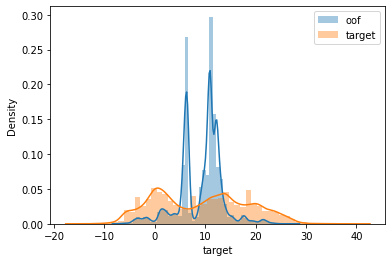

In [33]:
sns.distplot((oof),label = 'oof')
sns.distplot(df_train['target'],label = 'target')
plt.legend()
plt.show()

In [34]:
probs = 0
for i in models:
    probs = probs + (i.predict(df_test[feature_list]))
    
    print('fin_predict')
y_test_pred = probs/5.0
print(f'Real: ',math.sqrt(mean_squared_error(y_test_pred,df_test['Target'].values)))

fin_predict
fin_predict
fin_predict
fin_predict
fin_predict
Real:  8.037887773353624


In [66]:
y_submission['target'] = y_test_pred
y_submission.head()

,target
Index,
37320,8.610338
3913,6.213197
112180,12.352016
128820,12.360383
16037,6.213197


In [67]:
#Enviar los resultados
apiquery.submit_api(y_submission,
       competition_name='food',
        subname='test_v3', # Pueden cambiar esto sin problemas, poner el nombre que quieran.
        holdout_key='None',
        update_ldb=True,
        username="Insight ML - DD" # Poner el nombre de su equipo como un string. 
                                  # El mejor de los resultados dentro de sus envios es el que aparecera en la tabla de posiciones.
)

requests number 1
200
{'Date': 'Tue, 18 May 2021 15:35:42 GMT', 'Content-Type': 'application/json', 'Content-Length': '495', 'Connection': 'keep-alive', 'X-Request-ID': 'VNHZGWQD139YXTUI', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': 'POST', 'Access-Control-Allow-Headers': 'authorization,content-type'}


{'competition_name': 'food',
 'file_path': 'none',
 'message': 'Submission validated.',
 'name': 'Insight ML - DD',
 'result_csv_file': 'test_v3',
 'score': 8.037121275348136,
 'score2': None,
 'score3': None,
 'sub_name': 'test_v3',
 'sub_uid': 'c155b2f8-7859-4cd7-a052-dd12ca0b9c53',
 'submission_time': '2021/05/18, 15:35:42'}